In [1]:
import math
import numpy as np
import pandas as pd
import scipy as sc

import matplotlib.pyplot as plt
from scipy.integrate import quad, trapz, simps, cumtrapz

from scipy.interpolate import interp1d

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/almaz/miniconda3/envs/science/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['trapz']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Расчет

Некоторые константы

In [37]:
Q_EC_100Tc=0.172 #in MeV
Z_100Tc=43

g_a_g_v=1.297 #ratio of vector and axial coupling constants

BS05_OP_pep_ampl=1.42e8
pep_en=1.442 #MeV

Be384_en = 0.384 #Mev 
Be862_en = 0.862 #Mev

S_n = 6.764 #энергия отрыва нейтрона

total_GT = 0.72*(57-43)

Функция для расчета порога реакции

In [3]:
def Q_k_func(E_k, Q_EC):
    #Считаем порог реакции, E_k - энергия возбужденного состояния в BGT
    #E_k in KeV
    return Q_EC+E_k/1000

Привиденная энергия вылетающего электрона: $\epsilon_e = \frac{E_{\nu}-Q_k}{m_e} + 1$

In [4]:
def e_e_func(E_nu, E_k, Q_EC):
    #Считаем привиденную энергию вылетающего электрона. Если энергия налетающего нейтрино E_nu
    #меньше порога, возвращаем 0 для обнуления итогового сечения
    #E_nu in MeV
    q=Q_k_func(E_k, Q_EC) #порог реакции
    if E_nu>q: return 1+(E_nu-q)/0.511
    else: return 0 

Привиденный импульс электрона: $\pi_e=\sqrt{\epsilon_e^2 -1}$

In [5]:
def Pi_e_func(e_e):
    #Привиденный импульс электрона, вычисляется через привиденную энергию; ** означает степень  
    if e_e>1: return math.sqrt(e_e**2 - 1)
    else: return 0

In [6]:
def integrate_func(a, b, x, y):
    return np.sum( np.interp(x=np.arange(a, b, 0.001), xp=x, fp=y ) * 0.001 )

### Fermi-functions

In [7]:
Suslov_Z43 = pd.read_excel('../../fermi_func_tables/suslov/suslov_Z=42.xls')

def Suslov_func(x, Suslov_data=Suslov_Z43):
    #input привиденная энергия электрона
    f = interp1d(x=Suslov_data['E_kev']/511 + 1, y=Suslov_data['Value'], kind='linear', 
                 fill_value='extrapolate')
    return f(x)

In [8]:
Janecki_Z43 = pd.read_excel('../../fermi_func_tables/from_1968/Janecki Z43.xls')

def Janecki_func(e_e, Janecki_data=Janecki_Z43):
    #input привиденная энергия электрона 
    e_e3 = np.sqrt( np.square( Janecki_data['p0'].values ) + 1 )
    f = interp1d(x=e_e3, y= Janecki_data['Value'], kind='linear', fill_value='extrapolate')
    return f(e_e)

Ферми функция через гамму: $F(Z_f, E) = 2(\gamma_1+1)(2pR_{A})^{2(\gamma_1-1)}\frac{|\Gamma(\gamma_1+iy)|^2}{[\Gamma(2\gamma_1+1)]^2}e^{{\pi}y}$  
$y = \frac{{\alpha}Z_fE}{p}$, $\gamma_1 = \sqrt{1-(Z_f\alpha)^2}$, $R_A = 1.2A^{1/3}$ fm.  
E, p в единицах mc^2 и mc #см. начало Behrens and Janecki

In [9]:
def Fermi_via_Gamma(E, Z = Z_100Tc, A = 100):
    #input привиденная энергия электрона 
    alpha = 1/137
    
    #исключаем деление на ноль
    for_sqrt = E**2 - 1
    mask = for_sqrt > 0
    p = np.where(mask, np.sqrt(for_sqrt), 1)
    
    y = alpha*Z*E/p
    gamma1 = np.sqrt(1-(Z*alpha)**2)
    R = 1.2*np.cbrt(A)
    
    part1 = (2*gamma1+1)*(2*p*R)**(2*gamma1-2)
    part2 = np.square(np.abs(sc.special.gamma(gamma1+1j*y)))
    part3 = np.square(sc.special.gamma(2*gamma1+1))
    part4 = np.exp(np.pi*y)
    result = part1*(part2/part3)*part4
    return mask * result

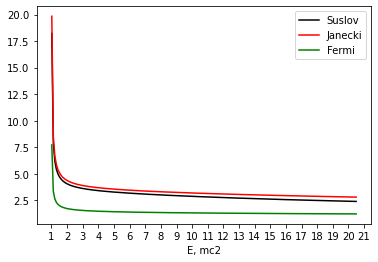

In [10]:
x_val = np.arange(0.01, 10, 0.05) / 0.511 + 1
plt.plot(x_val, Suslov_func(x_val), c='k', label = 'Suslov')
plt.plot(x_val, Janecki_func(x_val), c='r', label = 'Janecki')
plt.plot(x_val, [Fermi_via_Gamma(E) for E in x_val], c='g', label = 'Fermi')
plt.xticks(np.arange(1,22,1))
plt.legend()
plt.xlabel('E, mc2')
plt.show()

E_x до 5 МэВ!!!

In [11]:
BGT=pd.read_csv('../B(GT) peaks processing/recognition/Mo100/2012_discrete.csv') #таблица со значениями B(GT)
BGT.head()

,Ex,BGT,3-3.5,3.5-4
0,0,0.348,0.15,0.22
1,355,0.039,NaN,NaN
2,838,0.024,NaN,NaN
3,1339,0.041,NaN,NaN
4,1416,0.031,NaN,NaN


#### table B(GT) summ

In [12]:
table_BGT = np.sum(BGT['BGT'].values)
print(table_BGT)

0.5970000000000001


### BS05_OP flux

In [13]:
BS05OP_Be = 4.84e9
BS05OP_pp = 5.99e10
BS05OP_pep = 1.42e8
BS05OP_hep = 7.93e3
BS05OP_B = 5.69e6
BS05OP_N = 3.07e8
BS05OP_0 = 2.33e8
BS05OP_F = 5.84e6

In [14]:
step_all_fluxes = 0.001 #MeV
Energy_all_fluxes = np.arange(0,20,step_all_fluxes)

In [15]:
def return_flux(pp_ampl, hep_ampl, B_ampl, N_ampl, O_ampl, F_ampl, 
                energy_list = Energy_all_fluxes):
    pp = pd.read_excel('../Solar_neutrino_flux/pp.xls')
    b8 = pd.read_excel('../Solar_neutrino_flux/b8.xls')
    hep = pd.read_excel('../Solar_neutrino_flux/hep.xls')
    n13 = pd.read_excel('../Solar_neutrino_flux/n13.xls')
    o15 = pd.read_excel('../Solar_neutrino_flux/o15.xls')
    f17 = pd.read_excel('../Solar_neutrino_flux/f17.xls')

    flux = {
        'pp':np.interp(x=Energy_all_fluxes, xp=pp['Energy'].values, 
                       fp=pp['Probability'].values * pp_ampl ),
        'b8':np.interp(x=Energy_all_fluxes, xp=b8['Energy'].values, 
                       fp=b8['Probability'].values * B_ampl ),
        'hep':np.interp(x=Energy_all_fluxes, xp=hep['Energy'].values, 
                       fp=hep['Probability'].values * hep_ampl ),
        'n13':np.interp(x=Energy_all_fluxes, xp=n13['Energy'].values, 
                       fp=n13['Probability'].values * N_ampl ),
        'o15':np.interp(x=Energy_all_fluxes, xp=o15['Energy'].values, 
                       fp=o15['Probability'].values * O_ampl ),
        'f17':np.interp(x=Energy_all_fluxes, xp=f17['Energy'].values, 
                       fp=f17['Probability'].values * F_ampl ),
    }
    return flux

In [16]:
BS05OP_flux = return_flux(pp_ampl=BS05OP_pp, 
                          hep_ampl=BS05OP_hep,
                          B_ampl=BS05OP_B,
                          N_ampl=BS05OP_N,
                          O_ampl=BS05OP_0,
                          F_ampl=BS05OP_F)

### Cross-section and total rate

Сечение по Иджири $\sigma_k={(10^{-44}\ cm^2)}\times 1.597\cdot \epsilon_e \pi_e m_e^2 F(Z, \epsilon_e) [B(F)_k + (\frac{g_a}{g_v})^2 B(GT)_k] $ 

In [17]:
g_a_g_v_square = math.pow(g_a_g_v,2)
m_e_square = math.pow(0.511,2)

In [18]:
#расчет сечения до энергии возбуждения 5 МэВ
def sigma_k_less5(E_nu, E_k, BGT_k, Z, Q_EC, fermi_func):
    #E_k in kev
    #сечение k-го возб. состояния по Иджири
    e_e=e_e_func(E_nu, E_k, Q_EC) #энергия вылетающего электрона
    Pi_e=Pi_e_func(e_e) #его импульс
    F_col=fermi_func(e_e) #значение ферм-функции при такой энергии
    return 1.597*m_e_square*e_e*Pi_e*F_col*g_a_g_v_square*BGT_k

In [19]:
#функция расчета свертки сечения с потоком
def rate_calc(sigma, fluxes_dict, energies_array, step, func_pep_ampl = BS05OP_pep, 
              func_Be_ampl = BS05OP_Be, name = 'test1'):
    
    #const = 1.597*math.pow(10,-44)
    const = math.pow(10,-44)

    sigma_total = np.array(sigma) * const
    
    rate_total = 0
    
    output_dict = {'name':name}
    
    for elem in list(fluxes_dict.keys()):
        rate = sum(fluxes_dict[elem]*sigma_total*step) * math.pow(10,36)
        #print(elem, ' ', rate)
        output_dict[elem] = rate
        rate_total+=rate
        
    sigma_pep = np.interp(pep_en, xp=energies_array, fp=sigma_total)
    rate_pep = func_pep_ampl*sigma_pep*math.pow(10,36)
    #print('pep', ' ', rate_pep)
    output_dict['pep'] = rate_pep
    rate_total+=rate_pep
    
    sigma_Be384 = np.interp(Be384_en, xp=energies_array, fp=sigma_total)
    rate_Be384 = 0.103*func_Be_ampl*sigma_Be384*math.pow(10,36) #отношение из книжки бакала 
    
    sigma_Be862 = np.interp(Be862_en, xp=energies_array, fp=sigma_total)
    rate_Be862 = 0.897*func_Be_ampl*sigma_Be862*math.pow(10,36)
    rate_Be = rate_Be384 + rate_Be862
    
    #print('Be', ' ', rate_Be)
    output_dict['Be'] = rate_Be
    rate_total+=rate_Be
    
    #print('rate_total',' ', rate_total)
    output_dict['Total'] = rate_total
    return output_dict

In [20]:
sigma_less5_Janecki=[sum([sigma_k_less5(E_nu, E_k, BGT_k, Z_100Tc, Q_EC_100Tc, Janecki_func) 
                  for (BGT_k, E_k) in zip(BGT['BGT'].values, BGT['Ex'].values)]) 
             for E_nu in Energy_all_fluxes]

In [21]:
sigma_less5_Suslov=[sum([sigma_k_less5(E_nu, E_k, BGT_k, Z_100Tc, Q_EC_100Tc, Suslov_func) 
                  for (BGT_k, E_k) in zip(BGT['BGT'].values, BGT['Ex'].values)]) 
             for E_nu in Energy_all_fluxes]

In [22]:
sigma_less5_Fermi=[sum([sigma_k_less5(E_nu, E_k, BGT_k, Z_100Tc, Q_EC_100Tc, Fermi_via_Gamma) 
                  for (BGT_k, E_k) in zip(BGT['BGT'].values, BGT['Ex'].values)]) 
             for E_nu in Energy_all_fluxes]

/home/almaz/miniconda3/envs/science/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  
/home/almaz/miniconda3/envs/science/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp
/home/almaz/miniconda3/envs/science/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


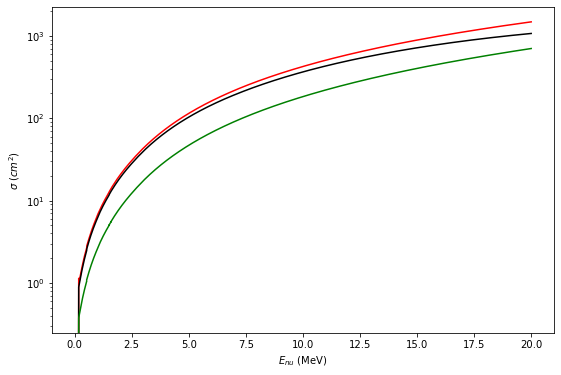

In [23]:
plt.figure(figsize=(9,6))
plt.plot(Energy_all_fluxes, sigma_less5_Janecki, c='r', label = 'Janecki discr')
plt.plot(Energy_all_fluxes, sigma_less5_Suslov, c='k', label = 'Suslov discr')
plt.plot(Energy_all_fluxes, sigma_less5_Fermi, c='g', label = 'Fermi discr')
plt.xlabel('$E_{nu}$ (MeV)')
plt.ylabel('$\sigma$ $(cm^2)$')
plt.yscale('log')
#plt.title('Сечение с учетом только дискретных состояний')

In [24]:
#функция для отрезки резонансов выше энергии отрыва
def border_func(x_data, y_data, border):
    a=np.where(x_data<border)
    #print(len(a[0]), len(x_data)-len(a[0]), len(x_data), a[0])
    return np.hstack(( y_data[a], np.zeros(len(x_data)-len(a[0])) ))


def border_func2(x_data, y_data, border_l, border_r):
    a=np.where(x_data<border_r)
    b=np.where(x_data>border_l)
    temp_y = np.hstack(( y_data[a], np.zeros(len(x_data)-len(a[0])) ))
    #print(len(a[0]), len(x_data)-len(a[0]), len(x_data), a[0])
    return np.hstack((np.zeros((b[0][0])), temp_y[b]))

Сечение для непрерывной части

$\sigma = {(10^{-44}\ cm^2)} \times \int^{z-Q}_{0} {1.597 \cdot (\frac{g_a}{g_v})^2 \cdot \sqrt{(z-Q-x+0.511)^2-0.511^2} \cdot (z-Q-x+0.511) \cdot S_{GTR}(x) \cdot F(z-Q-x+0.511)} dx $ 


In [25]:
#введем новую переменную p = z - Q
def sigma_k_GTR(x, p, x_data, y_data, fermi_func):
    e_energy = p - x + 0.511
    return 1.597*g_a_g_v_square*np.sqrt(e_energy**2-m_e_square)*e_energy\
    *np.interp(x,xp=x_data,fp=y_data)*fermi_func(e_energy/0.511) 


In [26]:
#разбиваем интервал интегрирования на субинтервалы
def intervals(a,b,n):
    c=np.linspace(a,b,num=n)
    return [[c[i], c[i+1]] for i in range(len(c)-1)]

In [27]:
#считаем сечение
def cross_sec(a,b, sigma_func, shape_x, shape_y, fermi_func, int_num=50):
    borders_list = intervals(a,b, int_num)
    #return sum([quad(sigma_func, i[0],i[1], args=(b,shape_x, shape_y))[0] for i in borders_list])
    return sum([sc.integrate.fixed_quad(sigma_func, i[0],i[1], args=(b,shape_x, shape_y, fermi_func))[0] for i in borders_list])
    #return sum([sc.integrate.romberg(sigma_func, i[0],i[1], args=(b,shape_x, shape_y)) for i in borders_list])

In [28]:
#continious part
bgt_cont_x1 = np.arange(3, 3.5, 0.01)
bgt_cont_y1 = np.ones(bgt_cont_x1.shape)
bgt_cont_y1 = bgt_cont_y1 / trapz(bgt_cont_y1, bgt_cont_x1) * BGT['3-3.5'][0]

bgt_cont_x2 = np.arange(3.5, 4, 0.01)
bgt_cont_y2 = np.ones(bgt_cont_x2.shape)
bgt_cont_y2 = bgt_cont_y2 / trapz(bgt_cont_y2, bgt_cont_x2) * BGT['3.5-4'][0]

bgt_cont_x0 = np.arange(0, 3, 0.01)
bgt_cont_y0 = np.zeros(bgt_cont_x0.shape)

bgt_cont_x3 = np.arange(4, 20, 0.01)
bgt_cont_y3 = np.zeros(bgt_cont_x3.shape)

bgt_cont_x = np.concatenate((bgt_cont_x0, bgt_cont_x1, bgt_cont_x2, bgt_cont_x3))
bgt_cont_y = np.concatenate((bgt_cont_y0, bgt_cont_y1, bgt_cont_y2, bgt_cont_y3))

trapz(bgt_cont_y1, bgt_cont_x1), trapz(bgt_cont_y2, bgt_cont_x2), trapz(bgt_cont_y, bgt_cont_x), bgt_cont_x.shape, bgt_cont_y.shape

(0.15, 0.21999999999999997, 0.3775510204081697, (2000,), (2000,))

In [29]:
p_list = np.arange(0,20, 0.01) #p = z - Q

In [30]:
sigma_cont_Janecki_temp = [cross_sec(0,p, sigma_k_GTR, bgt_cont_x, bgt_cont_y, Janecki_func, 200) for p in p_list]
sigma_cont_Janecki = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_100Tc, fp=sigma_cont_Janecki_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

In [31]:
sigma_cont_Suslov_temp = [cross_sec(0,p, sigma_k_GTR, bgt_cont_x, bgt_cont_y, Suslov_func, 200) for p in p_list]
sigma_cont_Suslov = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_100Tc, fp=sigma_cont_Suslov_temp)

In [32]:
sigma_cont_Fermi_temp = [cross_sec(0,p, sigma_k_GTR, bgt_cont_x, bgt_cont_y, Fermi_via_Gamma, 200) for p in p_list]
sigma_cont_Fermi = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_100Tc, fp=sigma_cont_Fermi_temp)

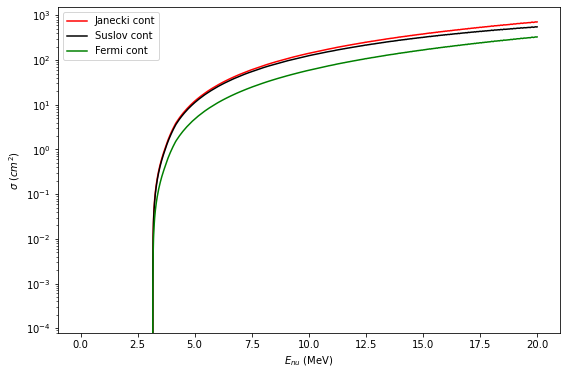

In [33]:
plt.figure(figsize=(9,6))
plt.plot(Energy_all_fluxes, sigma_cont_Janecki, c='r', label = 'Janecki cont')
plt.plot(Energy_all_fluxes, sigma_cont_Suslov, c='k', label = 'Suslov cont')
plt.plot(Energy_all_fluxes, sigma_cont_Fermi, c='g', label = 'Fermi cont')
plt.legend()
plt.xlabel('$E_{nu}$ (MeV)')
plt.ylabel('$\sigma$ $(cm^2)$')
plt.yscale('log')

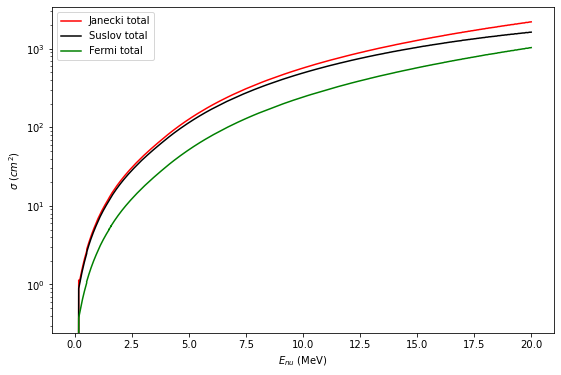

In [34]:
sigma_Janecki = sigma_cont_Janecki + sigma_less5_Janecki
sigma_Suslov = sigma_cont_Suslov + sigma_less5_Suslov
sigma_Fermi = sigma_cont_Fermi + sigma_less5_Fermi

plt.figure(figsize=(9,6))
plt.plot(Energy_all_fluxes, sigma_Janecki, c='r', label = 'Janecki total')
plt.plot(Energy_all_fluxes, sigma_Suslov, c='k', label = 'Suslov total')
plt.plot(Energy_all_fluxes, sigma_Fermi, c='g', label = 'Fermi total')
plt.legend()
plt.xlabel('$E_{nu}$ (MeV)')
plt.ylabel('$\sigma$ $(cm^2)$')
plt.yscale('log')

/home/almaz/miniconda3/envs/science/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/almaz/miniconda3/envs/science/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


Text(0.5, 0, '$E_{nu}$ (MeV)')

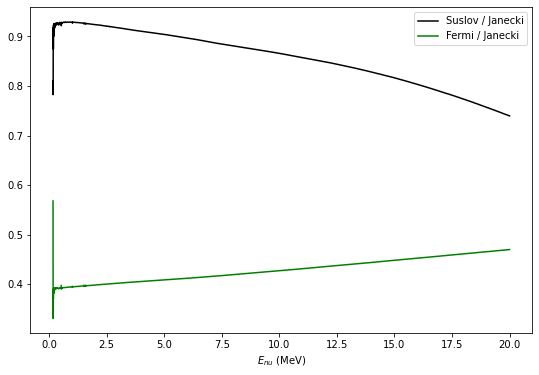

In [42]:
plt.figure(figsize=(9,6))
#plt.plot(Energy_all_fluxes, sigma_less5_Janecki, c='r', label = 'Janecki')
Suslov_Jan = sigma_Suslov / sigma_Janecki
Fermi_Jan = sigma_Fermi / sigma_Janecki

plt.plot(Energy_all_fluxes, Suslov_Jan, c='k', label = 'Suslov / Janecki')
plt.plot(Energy_all_fluxes, Fermi_Jan, c='g', label = 'Fermi / Janecki')
plt.legend()
plt.xlabel('$E_{nu}$ (MeV)')
#plt.ylabel('$\sigma$ $(cm^2)$')
#plt.yscale('log')

### BS05OP

In [38]:
rate_calc(sigma_Janecki, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'name': 'test1',
 'pp': 724.4629787924661,
 'b8': 16.556083940678743,
 'hep': 0.04736893369445871,
 'n13': 13.022998818540378,
 'o15': 16.469684287721236,
 'f17': 0.4147955772580219,
 'pep': 16.64351329167016,
 'Be': 240.49906012784976,
 'Total': 1028.1164837698789}

In [39]:
rate_calc(sigma_Suslov, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'name': 'test1',
 'pp': 666.4265410799834,
 'b8': 14.486319676124618,
 'hep': 0.04000136115386999,
 'n13': 12.08616389432639,
 'o15': 15.278371830355233,
 'f17': 0.38478681715625945,
 'pep': 15.429285757226479,
 'Be': 223.32561336786185,
 'Total': 947.4570837841881}

In [40]:
rate_calc(sigma_Fermi, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'name': 'test1',
 'pp': nan,
 'b8': nan,
 'hep': nan,
 'n13': nan,
 'o15': nan,
 'f17': nan,
 'pep': 6.601457878451593,
 'Be': 94.81391154531022,
 'Total': nan}